In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
from tqdm.notebook import tqdm
from sklearn.preprocessing import OrdinalEncoder
import time
from scipy import stats
import os
import pickle

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
path = "../input/m5-forecasting-accuracy"
calendar = reduce_mem_usage(pd.read_csv(os.path.join(path, "calendar.csv")))
selling_prices = reduce_mem_usage(pd.read_csv(os.path.join(path, "sell_prices.csv")))
sales = reduce_mem_usage(pd.read_csv(os.path.join(path, "sales_train_validation.csv")))

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 95.00 Mb (78.7% reduction)


In [4]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [5]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [6]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


Text(0.5, 1.0, 'event_name_2')

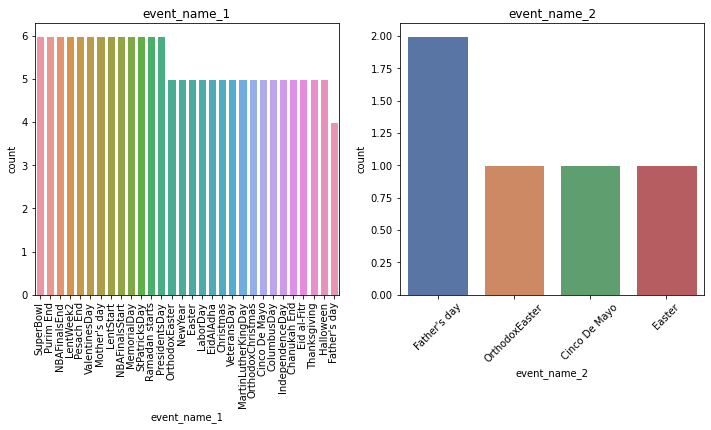

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=False)
sns.set(style="whitegrid")
e1 = sns.countplot(calendar['event_name_1'], order= calendar['event_name_1'].value_counts().index, label='event1', ax=ax[0])
e2 = sns.countplot(calendar['event_name_2'], order= calendar['event_name_2'].value_counts().index, label='event2', ax=ax[1])
e1.set_xticklabels(e1.get_xticklabels(), rotation=90)
e1.set_title('event_name_1')
e2.set_xticklabels(e2.get_xticklabels(), rotation=45)
e2.set_title('event_name_2')

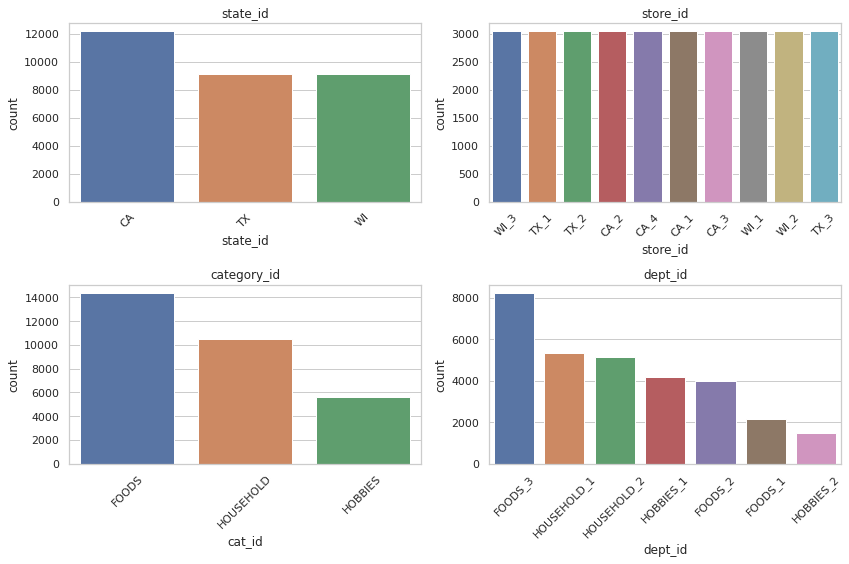

In [8]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=False)
sns.set(style="whitegrid")
d1 = sns.countplot(sales['state_id'], order= sales['state_id'].value_counts().index, label='state_id', ax=ax[0][0])
d2 = sns.countplot(sales['store_id'], order= sales['store_id'].value_counts().index, label='store_id', ax=ax[0][1])
d3 = sns.countplot(sales['cat_id'], order= sales['cat_id'].value_counts().index, label='cat_id', ax=ax[1][0])
d4 = sns.countplot(sales['dept_id'], order= sales['dept_id'].value_counts().index, label='dept_id', ax=ax[1][1])
d1.set_xticklabels(d1.get_xticklabels(), rotation=45)
d1.set_title('state_id')
d2.set_xticklabels(d2.get_xticklabels(), rotation=45)
d2.set_title('store_id')
d3.set_xticklabels(d3.get_xticklabels(), rotation=45)
d3.set_title('category_id')
d4.set_xticklabels(d4.get_xticklabels(), rotation=45)
d4.set_title('dept_id')
plt.tight_layout()

[Text(0, 0.5, 'Density'),
 Text(0.5, 0, 'Price'),
 Text(0.5, 1.0, 'Distribution without cutoff')]

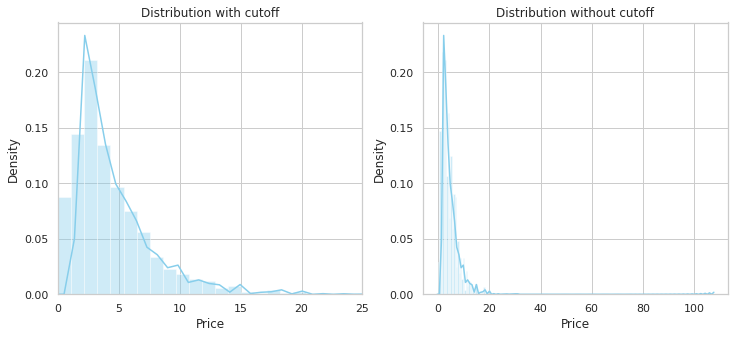

In [9]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=False)
sell_dist = sns.distplot(selling_prices['sell_price'], hist=True, color='skyblue', label='sell_dist', bins=100, ax=ax[0])
full_sell_dist = sns.distplot(selling_prices['sell_price'], hist=True, color='skyblue', label='sell_dist', bins=200, ax=ax[1])
sell_dist.set(title='Distribution with cutoff', ylabel='Density', xlabel = 'Price',  xlim=(0, 25))
full_sell_dist.set(title='Distribution without cutoff', ylabel='Density', xlabel = 'Price')

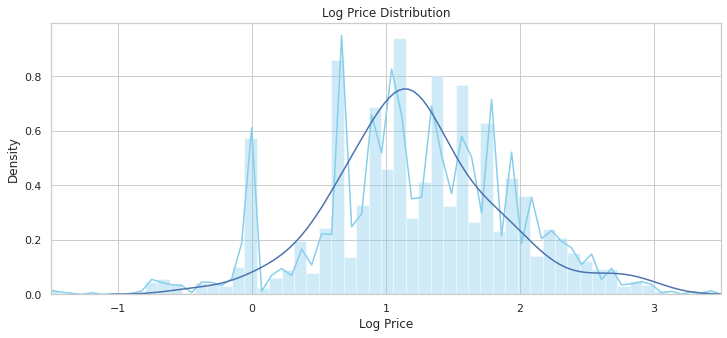

In [10]:
fig, ax = plt.subplots(1,1, figsize=(12,5), sharex=False)#
#sell_dist = sns.distplot(np.log(selling_prices['sell_price']), hist=True, color='skyblue', label='sell_dist', bins=100, ax=ax[0])
full_sell_dist = sns.distplot(np.log(selling_prices['sell_price']), hist=True, color='skyblue', label='sell_dist', bins=100, ax=ax)
full_sell_dist.set(title='Log Price Distribution', ylabel='Density', xlabel = 'Log Price', xlim=(-1.5,3.5))
#sell_dist.set(title='Log distribution with cutoff With Gaussian', ylabel='Probability', xlabel = 'Price',  xlim=(-5, 5))
x = np.random.normal(1.3, 0.6, size=100)
sns.kdeplot(x, ax=ax)

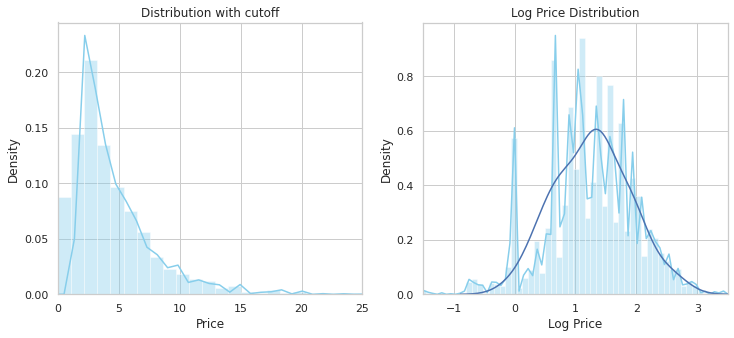

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=False)
sell_dist = sns.distplot(selling_prices['sell_price'], hist=True, color='skyblue', label='sell_dist', bins=100, ax=ax[0])
full_sell_dist = sns.distplot(np.log(selling_prices['sell_price']), hist=True, color='skyblue', label='sell_dist', bins=100, ax=ax[1])
full_sell_dist.set(title='Log Price Distribution', ylabel='Density', xlabel = 'Log Price', xlim=(-1.5,3.5))
sell_dist.set(title='Distribution with cutoff', ylabel='Density', xlabel = 'Price',  xlim=(0, 25))
x = np.random.normal(1.3, 0.6, size=100)
sns.kdeplot(x, ax=ax[1])

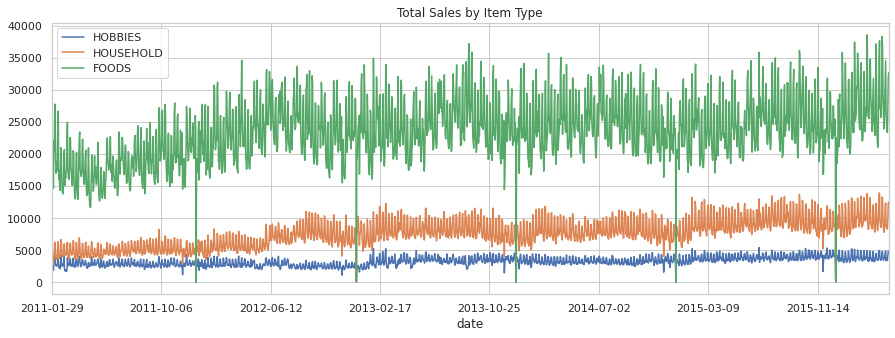

In [12]:
# adapted from https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration
d_cols = [c for c in sales.columns if r'd_' in c] # sales data columns
past_sales = sales.set_index('id')[d_cols].T.merge(calendar.set_index('d')['date'], left_index=True, right_index=True).set_index('date')

for i in sales['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(15, 5), title='Total Sales by Item Type')
plt.legend(sales['cat_id'].unique())
plt.show()

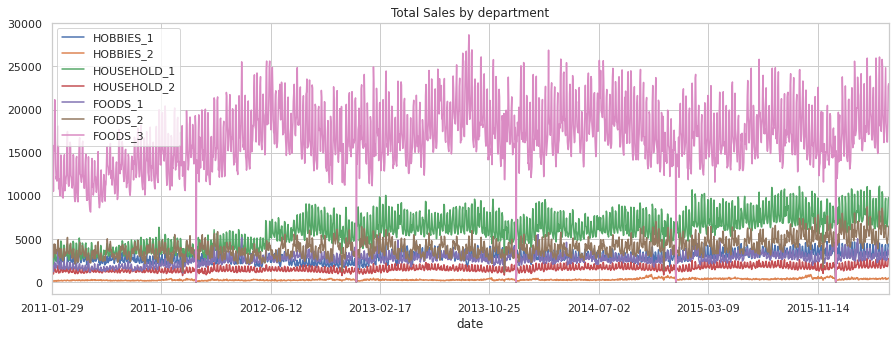

In [13]:
for i in sales['dept_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(15, 5), title='Total Sales by department')
plt.legend(sales['dept_id'].unique())
plt.show()

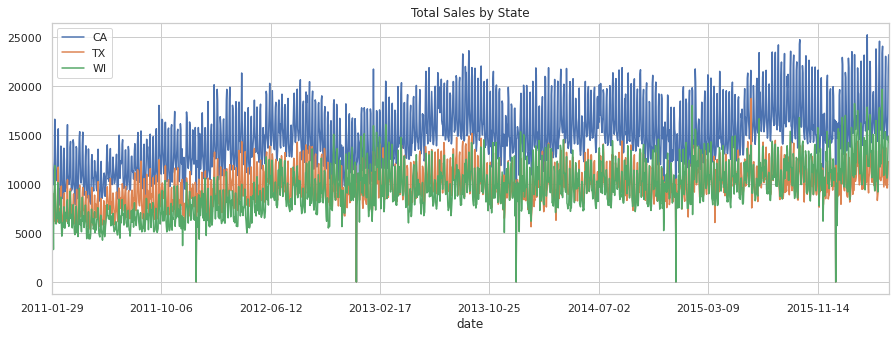

In [14]:
for i in sales['state_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(15, 5), title='Total Sales by State')
plt.legend(sales['state_id'].unique())
plt.show()

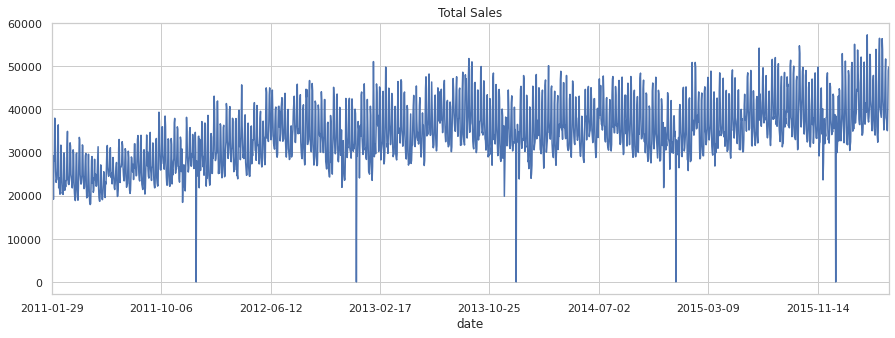

In [15]:
items_col = [c for c in past_sales.columns]
past_sales[items_col].sum(axis=1).plot(figsize=(15, 5), title='Total Sales')
plt.show()

In [16]:
encoder_file = open('encoders', 'wb')
'''
- The columns "Date" and "Weekday" are dropped as they contain redundant information.
- Normally, the column "d" is like "d_1,d_2,...". Make it "1,2,.." and the type integer
- If there is no event (I think), there is NA. We will replace them with "NoEvent" string. Originally, it was replaced with
  "missing", but I don't think it makes sense as I don't think there is missing information, I think they just left 
  the days without any event as NA.
- We enumerate most of the columns:
    - We do not enumerate "d" and "wm_yr_weak" because we will use these columns for joins.
    - Why do we enumerate month and day? I think it is because they start from 1, not 0.
    - Originally, the binary columns "snap_X" were also enumerated. I don't think it is necessary. The only neccessary step
      was to convert their type from int64 to int as it uses less space; but reduce_mem_usage will take care of that.
- I would suggest saving the OrdinalEncoder in case we need to reverse the transformations
'''
def prep_calendar(df,encoder_file):
    df = df.drop(["date", "weekday"], axis=1)  
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("NoEvent")
    cols = list(set(df.columns) - {"wm_yr_wk", "d","snap_CA","snap_TX","snap_WI"}) 
    oe = OrdinalEncoder(dtype="int")
    df[cols] = oe.fit_transform(df[cols])
    pickle.dump(oe,encoder_file)
    df = reduce_mem_usage(df)
    return df

'''
Got from: [1]
Originally, there were features added in this part. I excluded them until we decide whether to use those or not.
'''
def prep_selling_prices(df):
    df = reduce_mem_usage(df)
    return df

calendar = prep_calendar(calendar, encoder_file)

Mem. usage decreased to  0.03 Mb (79.6% reduction)


In [17]:
'''
Got from: [1]
- We drop the first "drop_d" days. Originally, this is set to 1000. When it is set to this value,
  the shape we get 29,544,810 rows. When we don't set it, we get 60,034,810 rows. I think for now 
  we can keep this functionality, as it may be useful if we would like to discard some of the days.
- In some id's, we have "_validation". Those are deleted.
- reindex: Conform DataFrame to new index with optional filling logic (obtained from pandas doc). 
  We add days 1914+2*28 to prepare data from submission
- We have to melt the sales dataframe since days are contained as columns.
- assign: Returns a new object with all original columns in addition to new ones. Existing columns 
  that are re-assigned will be overwritten (obtained from pandas doc). Again, we make the values 
  "d_1, d-2,..." to "1,2,..."
'''
#We have to melt sales for sure because the days are columns, which is not desirable.
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"))
    return df

sales = reshape_sales(sales)

[Text(0, 0.5, 'Density'),
 (0.0, 15.0),
 Text(0.5, 0, 'Demand'),
 Text(0.5, 1.0, 'Cutoff Demand Distribution')]

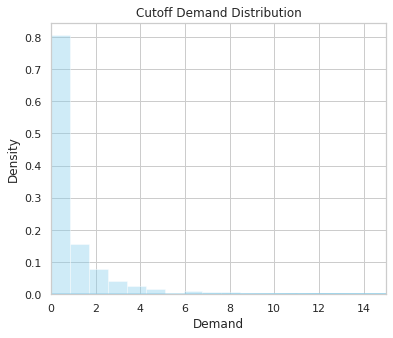

In [18]:
fig, ax = plt.subplots(1,1, figsize=(6,5), sharex=False)#
demand_dist_cutoff = sns.distplot(sales['demand'], hist=True, color='skyblue', label='demand_dist', bins = 900, ax=ax)
demand_dist_cutoff.set(title='Cutoff Demand Distribution', ylabel='Density', xlabel = 'Demand', xlim=(0,15))

[Text(0, 0.5, 'Density'),
 (0.0, 15.0),
 Text(0.5, 0, 'Demand'),
 Text(0.5, 1.0, 'Cutoff Demand Distribution')]

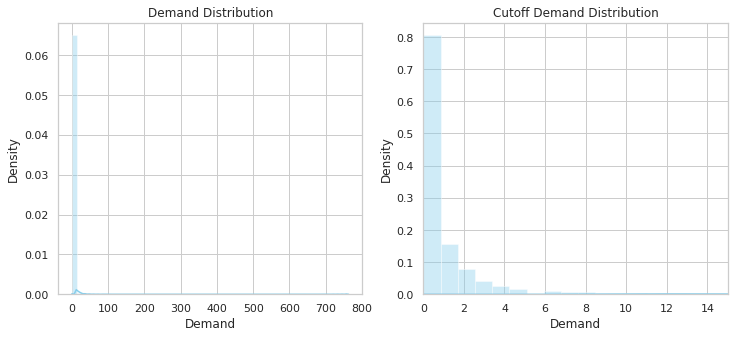

In [19]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=False)#
demand_dist = sns.distplot(sales['demand'], hist=True, color='skyblue', label='demand_dist', ax=ax[0])
demand_dist_cutoff = sns.distplot(sales['demand'], hist=True, color='skyblue', label='demand_dist', bins = 900, ax=ax[1])
demand_dist.set(title='Demand Distribution', ylabel='Density', xlabel = 'Demand')
demand_dist_cutoff.set(title='Cutoff Demand Distribution', ylabel='Density', xlabel = 'Demand', xlim=(0,15))

In [20]:
!pip install tweedie

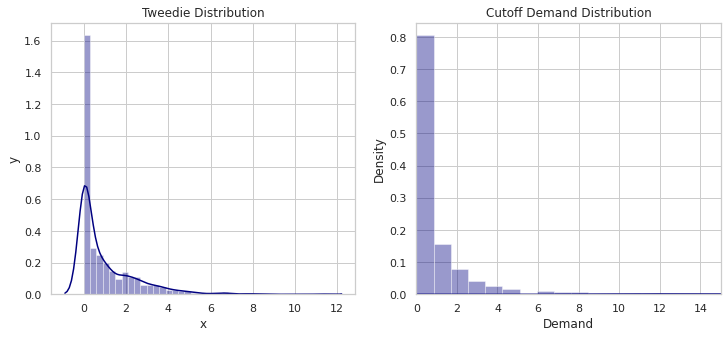

In [21]:
import tweedie
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=False)
tvs = tweedie.tweedie(mu=1, p=1.5, phi=2).rvs(1000)
tweedie = sns.distplot(tvs, color="navy", ax=ax[0])
demand_dist_cutoff = sns.distplot(sales['demand'], hist=True, color='navy', label='demand_dist', bins = 900, ax=ax[1])
demand_dist_cutoff.set(title='Cutoff Demand Distribution', ylabel='Density', xlabel = 'Demand', xlim=(0,15))
tweedie.set(title='Tweedie Distribution', ylabel='y', xlabel = 'x')
plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'tweedie'

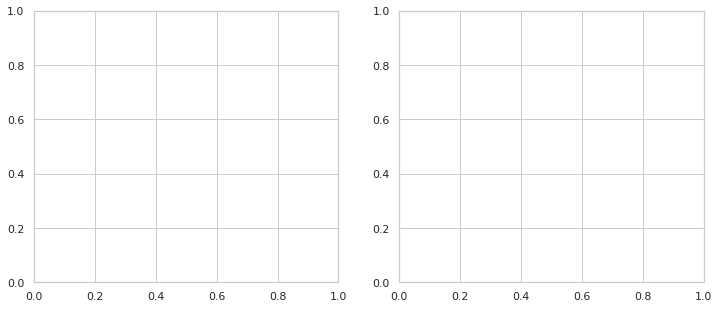

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=False)
tvs = tweedie.tweedie(mu=1, p=1.5, phi=2).rvs(10000)
tweedie = sns.distplot(tvs, color="skyblue", ax=ax[1])
demand_dist_cutoff = sns.distplot(sales['demand'], hist=True, color='skyblue', label='demand_dist', bins = 900, ax=ax[0])
demand_dist_cutoff.set(title='Cutoff Demand Distribution', ylabel='Density', xlabel = 'Demand', xlim=(0,15))
tweedie.set(title='Tweedie Distribution', ylabel='Density', xlabel = 'Count', xlim=(0,15))
plt.show()